# Image Classification Using a Deep CNN

In this notebook, we classify images between alive kudzu images and dead kudzu images.

The code in this notebook is based on the repository: [ImageClassification](https://github.com/nicknochnack/ImageClassification/tree/main).

You can also refer to the tutorial on YouTube: [Image Classification Tutorial](https://youtu.be/jztwpsIzEGc).

Before running the code, make sure to download the following file and save it to your AlivevsDeadKudzu repository:
- [Alive vs Dead Kudzu Dataset](https://www.kaggle.com/datasets/albaclosatarres/alive-vs-dead-kudzu-vegetation/)


## 1. Setup Requirements and Load Data


### 1.1 Install Dependencies and Setup

Follow this tutorial if want to use GPU https://www.xda-developers.com/use-gpu-jupyter-notebook/

In [ ]:
# Windows 
# !pip install opencv-python matplotlib keras
# obtain your pytorch version here: https://pytorch.org/get-started/locally/
# MacOS
# Run this command on the terminal: !conda install opencv matplotlib keras

In [ ]:
# check that librareis where installed correctly. You need: tensorflow, keras, opencv-python and matplotlib
# Windows 
#!pip list

# MacOS
!conda list

## GPU Correct Set Up Confirmation (skip if wanted to use CPU)

In [2]:
import torch

In [4]:
if torch.cuda.is_available():
    print(f"Found {torch.cuda.device_count()} GPU(s):")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("Failed to detect a GPU.")

Found 1 GPU(s):
GPU 0: NVIDIA RTX A6000


### 1.2 Remove Dodgy Images
Mislabeld images, currupt images.

In [5]:
import os
import cv2
import imghdr
from matplotlib import pyplot as plt

In [9]:
data_dir = 'data'

In [10]:
#your_directory = "YOUR_DIRECTORY_GOES_HERE"
your_directory = "/home/student/Desktop/KudzuClassification/ObjectDetection"

In [14]:
# Joining paths using os.path.join()
data_full_path = os.path.join(your_directory, data_dir)

# Display the joined path
print("Joined path:", data_full_path)

Joined path: /home/student/Desktop/KudzuClassification/ObjectDetection/data


In [15]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [16]:
# Windows
for image_class in os.listdir(data_full_path):
    for image in os.listdir(os.path.join(data_full_path, image_class)):
        image_path = os.path.join(data_full_path, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)
"""           
# MacOS
for image_class in os.listdir(data_full_path):
    class_path = os.path.join(data_full_path, image_class)
    # Check if the current path is a directory
    if not os.path.isdir(class_path):
        continue
    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)
        try:
            # Process the image
            pass
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")
"""

'           \n# MacOS\nfor image_class in os.listdir(data_full_path):\n    class_path = os.path.join(data_full_path, image_class)\n    # Check if the current path is a directory\n    if not os.path.isdir(class_path):\n        continue\n    for image in os.listdir(class_path):\n        image_path = os.path.join(class_path, image)\n        try:\n            # Process the image\n            pass\n        except Exception as e:\n            print(f"Error processing {image_path}: {str(e)}")\n'

### 1.3 Load Data

In [17]:
import numpy as np
from matplotlib import pyplot as plt

In [18]:
import cv2
import os

def crop_images_to_1x1(folder_path, output_folder=None):
    """
    Crop images in a folder to 1x1 aspect ratio if they are not close to 1x1.
    
    Args:
    - folder_path (str): Path to the folder containing images.
    - output_folder (str): Optional. Path to the folder to save cropped images. If not provided, images are displayed.
    """
    # Create output folder if it doesn't exist
    if output_folder and not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # List all files in the folder
    image_files = os.listdir(folder_path)
    num_images = len(image_files)
    print(f"Found {num_images} images in the folder {folder_path}")
    
    # Process each image
    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder_path, filename)
        img = cv2.imread(image_path)
        
        if img is None:
            print(f"Error reading image {filename}. Skipping...")
            continue
        
        # Get image dimensions
        height, width, _ = img.shape
        
        # Calculate aspect ratio
        aspect_ratio = width / height
        
        print(f"{filename} height= {height}, width= {width}, aspect_ratio= {aspect_ratio}  ")
        
        # Define the target size
        target_size = max(width, height)
        
        # Check aspect ratio and crop if necessary
        if aspect_ratio != 1:
            # Determine the region of interest (ROI) for cropping
            if width > height:
                # Landscape orientation
                crop_width = height
                crop_height = height
                start_x = (width - crop_width) // 2
                start_y = 0
            else:
                # Portrait orientation or square
                crop_width = width
                crop_height = width
                start_x = 0
                start_y = (height - crop_height) // 2
            
            # Crop the image
            cropped_img = img[start_y:start_y+crop_height, start_x:start_x+crop_width]
            
            # Resize cropped image to 1x1 aspect ratio
            resized_img = cv2.resize(cropped_img, (target_size, target_size), interpolation=cv2.INTER_AREA)
            
            height, width, _ = resized_img.shape
            aspect_ratio = width / height
        
            print(f"{filename} new height= {height}, width= {width}, aspect_ratio= {aspect_ratio}  ")
        
        else:
            # If aspect ratio is close to 1x1, use the original image
            resized_img = img
        
        # Save or display the resized image
        if output_folder:
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, resized_img)
        print(f"Finished resizing {filename}.")
    
    print(f"Finished resizing all images.")


In [19]:
# Joining paths using os.path.join()
data_full_path_alive = os.path.join(data_full_path, 'aliveKudzu')
data_full_path_dead = os.path.join(data_full_path, 'deadKudzu')

# Display the joined path
print("Joined path alive kudzu:", data_full_path_alive)
print("Joined path dead kudzu:", data_full_path_dead)



Joined path alive kudzu: /home/student/Desktop/KudzuClassification/ObjectDetection/data/aliveKudzu
Joined path dead kudzu: /home/student/Desktop/KudzuClassification/ObjectDetection/data/deadKudzu


In [20]:
crop_images_to_1x1(data_full_path_alive, data_full_path_alive)
crop_images_to_1x1(data_full_path_dead, data_full_path_dead)


Found 293 images in the folder /home/student/Desktop/KudzuClassification/ObjectDetection/data/aliveKudzu
images52.jpg height= 194, width= 259, aspect_ratio= 1.3350515463917525  
images52.jpg new height= 259, width= 259, aspect_ratio= 1.0  
Finished resizing images52.jpg.
Kudzu-by-Flickr-user-Kid-Doc-One-730x330.jpg height= 330, width= 730, aspect_ratio= 2.212121212121212  
Kudzu-by-Flickr-user-Kid-Doc-One-730x330.jpg new height= 730, width= 730, aspect_ratio= 1.0  
Finished resizing Kudzu-by-Flickr-user-Kid-Doc-One-730x330.jpg.
images226.jpg height= 181, width= 278, aspect_ratio= 1.5359116022099448  
images226.jpg new height= 278, width= 278, aspect_ratio= 1.0  
Finished resizing images226.jpg.
Kudzu-UF-IFAS-CAIP-1080x675.jpg height= 675, width= 1080, aspect_ratio= 1.6  
Kudzu-UF-IFAS-CAIP-1080x675.jpg new height= 1080, width= 1080, aspect_ratio= 1.0  
Finished resizing Kudzu-UF-IFAS-CAIP-1080x675.jpg.
images577.jpg height= 163, width= 310, aspect_ratio= 1.901840490797546  
images577.j

# 2. Preprocess

In [52]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transform with resizing
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Load dataset from directory
dataset = datasets.ImageFolder(root='data', transform=transform)

# Create DataLoader for batching
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [53]:
# Get a batch of data
data_iterator = iter(data_loader)
images, labels = next(data_iterator)

In [54]:
images.shape

torch.Size([32, 3, 512, 512])

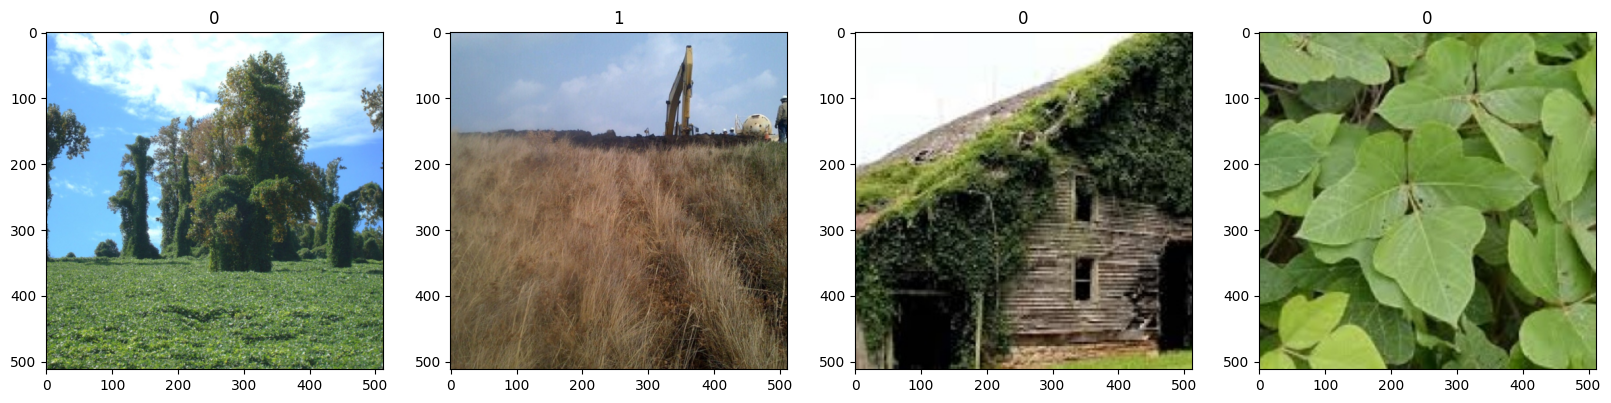

In [26]:
# Display images using Matplotlib
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(images[:4]):
    # Convert tensor image to numpy and transpose channels from [C, H, W] to [H, W, C] for plotting
    img = img.permute(1, 2, 0).numpy()
    ax[idx].imshow(img)
    ax[idx].title.set_text(labels[idx].item())  # Access the label

### 2.1 Scale Data

#### 2.1.1 Check that our data is scaled

In [27]:
print(images.min())  # Should be 0 (if scaled properly)
print(images.max())  # Should be 1 (if scaled properly)

tensor(0.)
tensor(1.)


### 2.2 Split Data

In [34]:
# 300 + 150 images = 450
# 80% train 10% validation 10% testing
# Define the sizes for train, val, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size


In [35]:
train_size

347

In [36]:
val_size

43

In [37]:
test_size

44

In [33]:
# Split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


In [38]:
train_size+val_size+test_size

434

In [40]:
# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [48]:
len(train_loader)+len(val_loader)+len(test_loader)

15

# 3. Deep Model

### 3.1 Build Deep Learning Models

## AlexNet

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim

#Define the AlexNet model
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # (3, 512, 512) -> (16, 512, 512)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (16, 512, 512) -> (16, 256, 256)
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (16, 256, 256) -> (32, 256, 256)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32, 256, 256) -> (32, 128, 128)
            
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),  # (32, 128, 128) -> (16, 128, 128)
            nn.ReLU(inplace=True),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (16, 128, 128) -> (32, 128, 128)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32, 128, 128) -> (32, 64, 64)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 64 * 64, 256),  # (32, 64, 64) -> 256
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate the model
alexnet = AlexNet()

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

## EfficientNet

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio):
        super(MBConvBlock, self).__init__()
        expanded_channels = in_channels * expand_ratio
        self.expand = nn.Conv2d(in_channels, expanded_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(expanded_channels)
        self.dwconv = nn.Conv2d(expanded_channels, expanded_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=expanded_channels, bias=False)
        self.bn2 = nn.BatchNorm2d(expanded_channels)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(expanded_channels, int(in_channels * se_ratio), kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(int(in_channels * se_ratio), expanded_channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.project = nn.Conv2d(expanded_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        x = F.relu6(self.bn1(self.expand(x)))
        x = F.relu6(self.bn2(self.dwconv(x)))
        x = self.se(x) * x
        x = self.bn3(self.project(x))
        if self.in_channels == self.out_channels and self.stride == 1:
            x = x + residual
        return x

class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=1):
        super(EfficientNetB0, self).__init__()
        
        # Stem layer
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        # MBConv blocks (based on EfficientNet-B0 architecture)
        self.block1 = MBConvBlock(32, 16, kernel_size=3, stride=1, expand_ratio=1, se_ratio=0.25)
        self.block2 = MBConvBlock(16, 24, kernel_size=3, stride=2, expand_ratio=6, se_ratio=0.25)
        self.block3 = MBConvBlock(24, 40, kernel_size=5, stride=2, expand_ratio=6, se_ratio=0.25)
        self.block4 = MBConvBlock(40, 80, kernel_size=3, stride=2, expand_ratio=6, se_ratio=0.25)
        self.block5 = MBConvBlock(80, 112, kernel_size=5, stride=1, expand_ratio=6, se_ratio=0.25)
        self.block6 = MBConvBlock(112, 192, kernel_size=5, stride=2, expand_ratio=6, se_ratio=0.25)
        self.block7 = MBConvBlock(192, 320, kernel_size=3, stride=1, expand_ratio=6, se_ratio=0.25)
        
        # Global pooling and fully connected layer
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(320, num_classes)  # 320 channels after MBConv blocks
    
    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)  # Flatten the output
        x = self.fc(x)
        return torch.sigmoid(x)  # For binary classification

# Instantiate the model
efficientnet = EfficientNetB0()

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary cross entropy for binary classification
optimizer = optim.Adam(efficientnet.parameters(), lr=0.001)


## Xception

In [101]:
class Xception(nn.Module):
    def __init__(self, num_classes=1):
        super(Xception, self).__init__()
        self.entry_flow = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.middle_flow = self._make_middle_flow(8, 64)  # Middle flow with 8 blocks
        self.exit_flow = nn.Sequential(
            nn.Conv2d(64, 1024, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1536, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(1536, 2048, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, num_classes)
    
    def _make_middle_flow(self, num_blocks, in_channels):
        layers = []
        for _ in range(num_blocks):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(in_channels)
            ))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.entry_flow(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return torch.sigmoid(x)

# Instantiate the model
xception = Xception()

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(xception.parameters(), lr=0.001)


## ResNet50

In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the basic residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)
        self.downsample = downsample  # Downsample layer to match dimensions
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out += residual
        out = self.relu(out)
        
        return out

# Define the full ResNet-50 model
class ResNet50(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet50, self).__init__()
        self.in_channels = 64
        
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(64, 3, stride=1)  # 3 residual blocks
        self.layer2 = self._make_layer(128, 4, stride=2)  # 4 residual blocks
        self.layer3 = self._make_layer(256, 6, stride=2)  # 6 residual blocks
        self.layer4 = self._make_layer(512, 3, stride=2)  # 3 residual blocks
        
        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)
    
    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4)
            )
        
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * 4  # Update the number of input channels
        
        for _ in range(1, blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

# Instantiate the model
resnet50 = ResNet50(num_classes=1)  # Assuming binary classification for your case

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)


### 3.2 Train

Check we are running this code with GPU by running the following code. Can be run with CPU it will just take longer.
- AlexNet: 18 minutes
- EfficientNet:
- Xception:
- ResNet:

In [103]:
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import time  # To calculate training time

In [104]:
# Create a SummaryWriter to log data for TensorBoard
writer = SummaryWriter(log_dir='logs')

In [113]:
import matplotlib.pyplot as plt
import time

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    start_time = time.time()  # Start the timer

    # Initialize lists to store metrics
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        
        # Training Loop
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)  # Convert labels to float

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs).squeeze()  # Squeeze the output to match the shape of labels
            loss = criterion(outputs, labels)
            preds = (outputs > 0.5).float()  # For binary classification

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        # Save training metrics for this epoch
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())
        
        # Validation Loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.float().to(device)  # Convert labels to float

                outputs = model(inputs).squeeze()  # Squeeze the output to match the shape of labels
                loss = criterion(outputs, labels)
                preds = (outputs > 0.5).float()

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        # Save validation metrics for this epoch
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())
        
        # Logging to TensorBoard
        writer.add_scalar(f'{model.__class__.__name__}/Training Loss', epoch_loss, epoch)
        writer.add_scalar(f'{model.__class__.__name__}/Training Accuracy', epoch_acc, epoch)
        writer.add_scalar(f'{model.__class__.__name__}/Validation Loss', val_loss, epoch)
        writer.add_scalar(f'{model.__class__.__name__}/Validation Accuracy', val_acc, epoch)

        print(f'Epoch {epoch}/{epochs - 1}')
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        print(f'--------------------------------')

    end_time = time.time()  # End the timer
    total_time = end_time - start_time
    print(f'Training time for {model.__class__.__name__}: {total_time:.2f} seconds')
    
    # Return model and training history
    return model, total_time, train_loss_history, train_acc_history, val_loss_history, val_acc_history


In [114]:
# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define loss function and optimizer for each model
criterion = nn.BCELoss()  # Binary cross-entropy loss


In [115]:
times = {}

#### Train AlexNet

In [117]:
print(f'\nTraining AlexNet')
alexnet = AlexNet().to(device)
optimizer_AN = torch.optim.Adam(alexnet.parameters(), lr=0.001)
trained_alexnet, alexnet_time, alexnet_train_loss, alexnet_train_acc, alexnet_val_loss, alexnet_val_acc = train_model(alexnet, 
                                                                                                                      train_loader, val_loader, criterion, optimizer_AN, epochs=20)
times['AlexNet'] = alexnet_time


Training AlexNet
Epoch 0/19
Train Loss: 0.6495 Acc: 0.6138
Val Loss: 0.5621 Acc: 0.7674
--------------------------------
Epoch 1/19
Train Loss: 0.6114 Acc: 0.7089
Val Loss: 0.4635 Acc: 0.7674
--------------------------------
Epoch 2/19
Train Loss: 0.4145 Acc: 0.7867
Val Loss: 0.2600 Acc: 0.9302
--------------------------------
Epoch 3/19
Train Loss: 0.2473 Acc: 0.8963
Val Loss: 0.2376 Acc: 0.9302
--------------------------------
Epoch 4/19
Train Loss: 0.2128 Acc: 0.9020
Val Loss: 0.1457 Acc: 0.9767
--------------------------------
Epoch 5/19
Train Loss: 0.1447 Acc: 0.9424
Val Loss: 0.1173 Acc: 0.9535
--------------------------------
Epoch 6/19
Train Loss: 0.1346 Acc: 0.9510
Val Loss: 0.1069 Acc: 0.9767
--------------------------------
Epoch 7/19
Train Loss: 0.1467 Acc: 0.9366
Val Loss: 0.1851 Acc: 0.9302
--------------------------------
Epoch 8/19
Train Loss: 0.0906 Acc: 0.9741
Val Loss: 0.1577 Acc: 0.9535
--------------------------------
Epoch 9/19
Train Loss: 0.0741 Acc: 0.9712
Val 

#### Train EfficientNet

In [ ]:
print(f'\nTraining EfficientNet')
efficientnet = EfficientNetB0().to(device)
optimizer_EN = torch.optim.Adam(efficientnet.parameters(), lr=0.001)
trained_efficientnet, efficientnet_time, efficientnet_train_loss, efficientnet_train_acc, efficientnet_val_loss, efficientnet_val_acc = train_model(efficientnet, train_loader, val_loader, criterion, optimizer_EN, epochs=20)
times['EfficientNet'] = efficientnet_time


Training EfficientNet
Epoch 0/19
Train Loss: 0.3963 Acc: 0.8530
Val Loss: 0.5649 Acc: 0.7674
--------------------------------
Epoch 1/19
Train Loss: 0.1957 Acc: 0.9251
Val Loss: 0.5739 Acc: 0.7674
--------------------------------
Epoch 2/19
Train Loss: 0.1586 Acc: 0.9568
Val Loss: 0.5898 Acc: 0.7674
--------------------------------
Epoch 3/19
Train Loss: 0.2158 Acc: 0.9107
Val Loss: 0.3264 Acc: 0.8605
--------------------------------
Epoch 4/19
Train Loss: 0.1432 Acc: 0.9481
Val Loss: 0.2038 Acc: 0.9070
--------------------------------
Epoch 5/19
Train Loss: 0.1752 Acc: 0.9424
Val Loss: 0.2157 Acc: 0.9302
--------------------------------
Epoch 6/19
Train Loss: 0.1269 Acc: 0.9597
Val Loss: 0.1296 Acc: 0.9535
--------------------------------
Epoch 7/19
Train Loss: 0.0682 Acc: 0.9741
Val Loss: 0.1165 Acc: 0.9535
--------------------------------
Epoch 8/19
Train Loss: 0.0445 Acc: 0.9798
Val Loss: 0.0968 Acc: 0.9767
--------------------------------
Epoch 9/19
Train Loss: 0.0336 Acc: 0.9914

#### Train Xception

In [ ]:
xception = Xception().to(device)
optimizer_X = torch.optim.Adam(xception.parameters(), lr=0.001)
trained_xception, xception_time, xception_train_loss, xception_train_acc, xception_val_loss, xception_val_acc = train_model(xception, train_loader, val_loader, criterion, optimizer_X, epochs=20)
times['Xception'] = xception_time

#### Train ResNet50

In [ ]:
resnet50 = ResNet50().to(device)
optimizer_RN = torch.optim.Adam(resnet50.parameters(), lr=0.001)
trained_resnet50, resnet50_time, resnet50_train_loss, resnet50_train_acc, resnet50_val_loss, resnet50_val_acc = train_model(resnet50, train_loader, val_loader, criterion, optimizer_RN, epochs=20)
times['ResNet-50'] = resnet50_time

Print Out Times

In [ ]:
# Print out training times
for model_name, train_time in times.items():
    print(f'{model_name} took {train_time:.2f} seconds to train')

# Close the TensorBoard writer
writer.close()

### 3.3 Plot Performance

In [ ]:
def plot_multiple_models_loss(train_losses, val_losses, model_names):
    epochs = range(1, len(train_losses[0]) + 1)

    # Create a figure for comparing loss values
    plt.figure(figsize=(10, 6))

    # Plot training and validation loss for each model
    for i, model_name in enumerate(model_names):
        plt.plot(epochs, train_losses[i], label=f'{model_name} Train Loss')
        plt.plot(epochs, val_losses[i], '--', label=f'{model_name} Val Loss')

    plt.title('Training and Validation Loss for Multiple Models')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_performance(train_loss_history, train_acc_history, val_loss_history, val_acc_history)


## Feature Map

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Function to visualize feature maps
def visualize_feature_maps(model, img_tensor, layer, num_filters=16):
    model.eval()  # Set the model to evaluation mode

    # Forward pass through the model up to the desired layer
    with torch.no_grad():
        activations = layer(img_tensor)

    # Normalize the feature maps
    activations = activations - activations.min()
    activations = activations / activations.max()

    # Plot the feature maps
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))  # 4x4 grid for 16 filters
    for i in range(num_filters):
        row = i // 4
        col = i % 4
        ax = axes[row][col]
        ax.imshow(activations[0, i].cpu().numpy(), cmap='viridis')  # Convert to numpy for visualization
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Function to get all convolutional layers in the model
def get_conv_layers(model):
    conv_layers = []
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            conv_layers.append(layer)
        elif isinstance(layer, nn.Sequential):  # If the model contains sequential layers
            for sub_layer in layer.children():
                if isinstance(sub_layer, nn.Conv2d):
                    conv_layers.append(sub_layer)
    return conv_layers

# Load and preprocess the image
def preprocess_image(img_path, target_size=(512, 512)):
    img = Image.open(img_path).convert('RGB')
    
    preprocess = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
    return img_tensor


In [ ]:

# Load the image file and preprocess
img_path = "/path/to/your/image.jpg"
img_tensor = preprocess_image(img_path, target_size=(512, 512))


In [ ]:
for model_name, train_time in training_times.items():
    # Assuming 'efficientnet' or any CNN model is your pre-trained model
    conv_layers = get_conv_layers(model_name)  # Replace with your model's instance
    print(f"Found {len(conv_layers)} convolutional layers in {model_name}.")
    
    # Visualize feature maps for each convolutional layer
    for i, layer in enumerate(conv_layers):
        print(f"Visualizing feature maps for layer {i + 1} in  {model_name}")
        visualize_feature_maps(efficientnet, img_tensor, layer)


# 4. Evaluate

### 4.1 Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import torch

# Step 1: Make Predictions
def get_predictions(model, test_loader, device):
    y_true = []
    y_pred = []
    
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for batch in test_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass: get predictions
            outputs = model(images)
            
            # Assuming binary classification, convert probabilities to class labels
            predicted_labels = (outputs > 0.5).cpu().numpy().astype(int)

            # Collect true and predicted labels
            y_true.extend(labels.cpu().numpy().flatten())  # Convert to numpy and flatten if necessary
            y_pred.extend(predicted_labels.flatten())  # Flatten if necessary
    
    return np.array(y_true), np.array(y_pred)

# Example usage: Get predictions for each model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

y_true1, y_pred1 = get_predictions(alexnet, test_loader, device)
y_true2, y_pred2 = get_predictions(effic, test_loader, device)
y_true3, y_pred3 = get_predictions(Xception, test_loader, device)
y_true3, y_pred3 = get_predictions(Xception, test_loader, device)

# Step 2: Calculate Metrics
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
    
    return precision, recall, accuracy, f1

# Calculate metrics for each model
precision1, recall1, accuracy1, f11 = calculate_metrics(y_true1, y_pred1)
precision2, recall2, accuracy2, f12 = calculate_metrics(y_true2, y_pred2)
precision3, recall3, accuracy3, f13 = calculate_metrics(y_true3, y_pred3)
precision4, recall4, accuracy4, f14 = calculate_metrics(y_true3, y_pred3)

# Step 3: Print Results in percentages with two decimal places
print(f"AlexNet - Precision: {precision1 * 100:.2f}%, Recall: {recall1 * 100:.2f}%, Accuracy: {accuracy1 * 100:.2f}%, F1 Score: {f11 * 100:.2f}%")
print(f"EfficientNet - Precision: {precision2 * 100:.2f}%, Recall: {recall2 * 100:.2f}%, Accuracy: {accuracy2 * 100:.2f}%, F1 Score: {f12 * 100:.2f}%")
print(f"Xception - Precision: {precision3 * 100:.2f}%, Recall: {recall3 * 100:.2f}%, Accuracy: {accuracy3 * 100:.2f}%, F1 Score: {f13 * 100:.2f}%")
print(f"Xception - Precision: {precision3 * 100:.2f}%, Recall: {recall3 * 100:.2f}%, Accuracy: {accuracy3 * 100:.2f}%, F1 Score: {f13 * 100:.2f}%")


### 4.2 Test

Import libraries to test and classify the images in the output folder that we downloaded using Google Street View.

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import shutil

Define all the paths to the folder where we have all the images we downloaded and we want to classify and also the folders to save each image once is classified.

In [ ]:
# Redifine you images paths
images_dir = "output"
alive_dir = "output/alive"
dead_dir = "output/dead"

In [ ]:
# Redifine you images paths
images_full_path = os.path.join(your_directory, images_dir) 
alive_full_path = os.path.join(your_directory, alive_dir)
dead_full_path = os.path.join(your_directory, dead_dir) 

# Create 
if not os.path.exists(alive_full_path):
    os.makedirs(alive_full_path)
if not os.path.exists(dead_full_path):
    os.makedirs(dead_full_path)

In [ ]:

# Display the joined path
print("Images path:", images_full_path)
print("Alive Images path:", alive_full_path)
print("Dead Images path:", dead_full_path)

In [ ]:
# List all the image files in the directory
image_files = os.listdir(images_full_path)

In [ ]:
len(image_files)

## Select model according to evaluation results

In [ ]:
model = AlexNet
model.summary()

In [ ]:
# Initialize the dictionary to store yhat values
yhat_values = {}

alive_count = 0
dead_count = 0

for image_file in image_files:
    # Read the image
    img = cv2.imread(os.path.join(images_full_path, image_file))

    # Check if the image is successfully loaded
    if img is None:
      print(f"Error: Unable to read image {image_file}")
      continue  # Skip to the next image if loading fails

    # Convert color space from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image
    resize = tf.image.resize(img_rgb, (512, 512))

    # Preprocess the image for prediction
    preprocessed_img = resize / 255.0

    # Make predictions using the model
    yhat = model.predict(np.expand_dims(preprocessed_img, axis=0))

    # Determine the predicted class
    if yhat > 0.5:
        predicted_class = 'Dead'
        destination_folder = dead_full_path
        dead_count = dead_count + 1
        #print(f'Dead Images = {dead_count}')
    else:
        predicted_class = 'Alive'
        destination_folder = alive_full_path
        alive_count = alive_count + 1
        #print(f'Alive Images = {alive_count}')
        # Store the yhat value in the dictionary
        yhat_values[image_file] = yhat[0][0]

    # Save the image to the respective classification folder
    image_path = os.path.join(destination_folder, image_file)
    cv2.imwrite(image_path, img)

    #print(f'Image {image_file} is predicted as {predicted_class} and saved to {destination_folder}')

In [ ]:
print(f'Alive Images = {alive_count}')
print(f'Dead Images = {dead_count}')
print(f' Images = {dead_count + alive_count}')


In [ ]:
sorted_yhat_values_alive = dict(sorted(yhat_values.items(), key=lambda item: item[1]))
print(sorted_yhat_values_alive)

# 5. Top 20%

In [ ]:
import os
import cv2
import shutil

# Define the destination folder to save the images
destination_folder = "C:/Users/Rojano/Desktop/alive/top20"  # Update with the path to your destination folder

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Counter for saving the first 20% of the images
count = 0
top20 = len(sorted_yhat_values_alive) * 0.20
print(top20)


In [ ]:
# Loop through the first 20% of the images in the sorted dictionary
for image_file, yhat_value in sorted_yhat_values_alive.items():
    if count >= top20:
        break

    # Copy the image file to the destination folder
    source_path = os.path.join(images_full_path, image_file)
    destination_path = os.path.join(destination_folder, image_file)
    shutil.copyfile(source_path, destination_path)

    # Increment the counter
    count += 1

print(f"First {count} images saved to the {destination_folder}.")


In [ ]:
# List all files and directories in the folder
files = os.listdir(destination_folder)

# Count the number of files (excluding directories)
num_files = len(files)

print("Number of files in the folder:", num_files)


## Display images 

In [ ]:
# Iterate through the files in the destination folder
for count, image_file in enumerate(os.listdir(destination_folder), 1):
    # Read the image
    img = cv2.imread(os.path.join(destination_folder, image_file))

    # Display the image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{count}. {image_file}")
    plt.axis('off')
    plt.show()

In [ ]:
# Save the model
AlexNet.save('alexnet_model.h5')